Method of determining the smallest allowable size to split open field sessions into while retaining behavioural characteristics (section Data Augmentation in thesis).

In [3]:
%matplotlib inline
%pylab inline
import collections, itertools, datetime, warnings
import numpy as np
import pandas as pd
import xarray as xr
import sklearn, sklearn.model_selection, sklearn.naive_bayes, sklearn.tree, sklearn.neural_network, sklearn.neighbors, sklearn.ensemble
import matplotlib.pyplot as plt
import matplotlib

import datasets

Populating the interactive namespace from numpy and matplotlib


In [4]:
ds = datasets.load('2014')

In [5]:
def segment_time(ds,segment_size=datetime.timedelta(minutes=10)):
    n_segments = int(np.ceil(ds.time[-1] / np.timedelta64(segment_size)))
    segment = range(n_segments)
    new_time = ds.time[:len(ds.time)//n_segments]
    ind = pd.MultiIndex.from_product((segment,new_time),names=('part','new_time'))
    r = ds.assign(time=ind).unstack('time').rename({'new_time':'time'})
    return r

In [6]:
segments = segment_time(ds).stack(segment=('rat','session','part')).reset_index('segment')
datasets.save(segments, '2014_segments', overwrite=True)

In [5]:
def ds_features(ds):
    return np.vstack((ds.mean('time').to_array(),ds.std('time').to_array())).T # mean and std of variables
    #return ds.isel(time=0).to_array().T
    #return [[0]]*len(ds.treatment)

simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier]
    
def ds_clf_score(ds):
    X,y = ds_features(ds), ds.treatment.values
    cv = sklearn.model_selection.StratifiedKFold(40,True)
    r = {}
    for classifier in simple_classifiers:
        clf = classifier()
        v = np.stack(sklearn.model_selection.cross_val_score(clf,X,y,cv=cv,scoring='f1_weighted') for _ in range(10))
        print(classifier.__name__, v.mean(), v.std())
        r[classifier.__name__] = v
    return r

In [6]:
def segment_and_score(ds,segment_size=datetime.timedelta(minutes=10)):
    s = segment_time(ds,segment_size).stack(fragment=['rat','segment','session'])
    return ds_clf_score(s)

In [37]:
r = {}
for i in [30,15,10,7.5,6,5,3,2,1,0.5,0.25,0.1][::2]:
    t = datetime.timedelta(minutes=i)
    print(f'segment size: {t}')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        v = segment_and_score(ds,t)
        r[i] = v
    print('-'*100)

segment size: 0:30:00
GaussianNB 0.881083333333 0.265215727182
DecisionTreeClassifier 0.809416666667 0.312592552961
MLPClassifier 0.520333333333 0.352983946755
KNeighborsClassifier 0.793166666667 0.319318675725
RandomForestClassifier 0.845666666667 0.286129535545
----------------------------------------------------------------------------------------------------
segment size: 0:10:00
GaussianNB 0.727493446368 0.183233046165
DecisionTreeClassifier 0.764744708995 0.178588563704
MLPClassifier 0.63773977874 0.205790661286
KNeighborsClassifier 0.801116281866 0.17236989487
RandomForestClassifier 0.844176527177 0.156562615373
----------------------------------------------------------------------------------------------------
segment size: 0:06:00
GaussianNB 0.717933073218 0.133469424461
DecisionTreeClassifier 0.80512987217 0.123966476875
MLPClassifier 0.682746945048 0.197229336002
KNeighborsClassifier 0.784387103746 0.12622399974
RandomForestClassifier 0.843795659406 0.114713738529
----------

KeyboardInterrupt: 

In [14]:
s = segment_time(ds,segment_size).stack(fragment=['rat','segment','session'])

NameError: name 'segment_size' is not defined

In [14]:
clf = sklearn.neighbors.KNeighborsClassifier()
segment_size = datetime.timedelta(minutes=0.25)
s = segment_time(ds,segment_size).stack(fragment=['rat','segment','session'])
X = ds_features(s)
y = s.treatment
clf.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
import statsmodels

In [9]:
clf.predict([X[0]])

array(['s'], dtype=object)

In [10]:
clf.score(X,y)

0.85364583333333333

In [125]:
features_samples = X[clf.kneighbors(X,5)[1]]
(features_samples.std(axis=1) / features_samples.mean(axis=1)).mean(axis=0)

array([ 0.04911513,  0.18620659, -0.01987764,  0.07662365,  0.10494275,
        0.27428717, -0.10933564,  0.21589592,  0.22097451,  0.11594742,
        0.24962098,  0.10494275,  0.37691229,  0.37505211])

In [147]:
i = 0
s.treatment[i].values,s.isel(fragment=clf.kneighbors(X,5)[1][i]).treatment.values

(array('s', 
       dtype='<U1'), array(['s', 'q', 's', 's', 'q'], dtype=object))

In [104]:
ds.sel(rat=ds.treatment=='s').direction.mean(), ds.sel(rat=ds.treatment=='q').direction.mean()

(<xarray.DataArray 'direction' ()>
 array(-22.86541946748036), <xarray.DataArray 'direction' ()>
 array(-3.2013395081177074))

In [30]:
def f(*x):
    return list((enumerate(zip(*x))))

In [31]:
f(X[s.treatment=='s'].mean(axis=0), X[s.treatment=='q'].mean(axis=0))

[(0, (62.917035918123958, 65.968381236577812)),
 (1, (4.2021895349974878, 9.5324123541431636)),
 (2, (-22.865970053659652, -3.1945388956825265)),
 (3, (0.6193026715801816, 0.63708568912446717)),
 (4, (7.8559999999999244, 7.7264000000002486)),
 (5, (6.7758235827788704, 2.8522727257452782)),
 (6, (31.82835115570067, 35.715836506577162)),
 (7, (6.4944922011833084, 9.2886534115788209)),
 (8, (3.8089887893784322, 6.6995283726132389)),
 (9, (50.247691471053486, 80.085878250391801)),
 (10, (0.087677495074155301, 0.11625069125880982)),
 (11, (7.8559999999999244, 7.7264000000002486)),
 (12, (8.4315844777477373, 16.065224257141271)),
 (13, (7.7797989244544024, 17.140824799577715))]

In [32]:
f(X[s.treatment=='s'].std(axis=0), X[s.treatment=='q'].std(axis=0))

[(0, (12.000865544562961, 9.3441076819611677)),
 (1, (2.6097786077463998, 5.875747871511602)),
 (2, (81.402611148299172, 51.313631092694287)),
 (3, (0.14210849284644994, 0.081924341610255996)),
 (4, (1.2601629524258833, 1.1534812698956014)),
 (5, (45.520148207289232, 31.243438732645878)),
 (6, (46.757017206521013, 35.883999114862725)),
 (7, (3.932797156935115, 3.2890726884645365)),
 (8, (2.891388088579312, 3.753180247695092)),
 (9, (44.895083673289115, 32.972964986237592)),
 (10, (0.048580449216710585, 0.038192654476100589)),
 (11, (1.2601629524258833, 1.1534812698956014)),
 (12, (12.044972841714785, 12.882126101818697)),
 (13, (12.480425799067808, 15.880046867549952))]

In [15]:
X['variable']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [23]:
X[s.treatment=='s'].mean(axis=0)

array([ 62.91703592,   4.20218953, -22.86597005,   0.61930267,
         7.856     ,   6.77582358,  31.82835116,   6.4944922 ,
         3.80898879,  50.24769147,   0.0876775 ,   7.856     ,
         8.43158448,   7.77979892])

In [24]:
X[s.treatment=='q'].mean(axis=0)

array([ 65.96838124,   9.53241235,  -3.1945389 ,   0.63708569,
         7.7264    ,   2.85227273,  35.71583651,   9.28865341,
         6.69952837,  80.08587825,   0.11625069,   7.7264    ,
        16.06522426,  17.1408248 ])

In [27]:
X[s.treatment=='s'].std(axis=0)

array([  1.20008655e+01,   2.60977861e+00,   8.14026111e+01,
         1.42108493e-01,   1.26016295e+00,   4.55201482e+01,
         4.67570172e+01,   3.93279716e+00,   2.89138809e+00,
         4.48950837e+01,   4.85804492e-02,   1.26016295e+00,
         1.20449728e+01,   1.24804258e+01])

In [28]:
X[s.treatment=='q'].std(axis=0)

array([  9.34410768e+00,   5.87574787e+00,   5.13136311e+01,
         8.19243416e-02,   1.15348127e+00,   3.12434387e+01,
         3.58839991e+01,   3.28907269e+00,   3.75318025e+00,
         3.29729650e+01,   3.81926545e-02,   1.15348127e+00,
         1.28821261e+01,   1.58800469e+01])

In [11]:
import pickle
pickle.dump(r,open("split_data.p", "wb"))

In [9]:
import pickle
pickle.load(open("split_data.p", "rb"))

{0.5: {'DecisionTreeClassifier': array([[ 0.82703122,  0.84310345,  0.87645087,  0.81478405,  0.89141677,
           0.84130144,  0.8       ,  0.85727969,  0.86721504,  0.90041128,
           0.82537429,  0.86666667,  0.83253589,  0.90916515,  0.87471166,
           0.87471166,  0.87645087,  0.84260478,  0.81857639,  0.84130144,
           0.9170094 ,  0.89141677,  0.8761343 ,  0.85551761,  0.86767706,
           0.78333333,  0.88333333,  0.82152176,  0.83162187,  0.85      ,
           0.85113669,  0.9007578 ,  0.83544122,  0.89952153,  0.88333333,
           0.90041128,  0.8492823 ,  0.89897312,  0.83851968,  0.86721504],
         [ 0.87526735,  0.84200531,  0.86767706,  0.87471166,  0.89141677,
           0.8464804 ,  0.810558  ,  0.86767706,  0.85061692,  0.89230854,
           0.87471166,  0.89952153,  0.8591727 ,  0.89086094,  0.89230854,
           0.81742068,  0.8591727 ,  0.87526735,  0.89897312,  0.9       ,
           0.89086094,  0.8591727 ,  0.86721504,  0.89141677,  0.875

In [15]:
print([i+1 for i in range(300) if datetime.timedelta(minutes=30/(i+1)).microseconds == 0])

[1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 25, 30, 36, 40, 45, 50, 60, 72, 75, 90, 100, 120, 150, 180, 200, 225, 300]


In [22]:
i = 30
t = datetime.timedelta(minutes=i)
t = t - datetime.timedelta(microseconds=t.microseconds)
segment_time(ds,t)

<xarray.Dataset>
Dimensions:      (part: 1, rat: 8, session: 10, time: 45000)
Coordinates:
  * rat          (rat) object '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) object 'injection1' 'injection2' 'injection3' ...
    treatment    (rat) object 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) object '5' '17' '29' '41' '53' '65' '77' ...
  * part         (part) int64 0
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
Data variables:
    area         (rat, session, part, time) float64 58.74 58.31 51.87 51.18 ...
    areachange   (rat, session, part, time) float64 14.86 13.48 12.28 11.85 ...
    direction    (rat, session, part, time) float64 147.6 137.3 135.0 129.3 ...
    elongation   (rat, session, part, time) float64 0.7867 0.7429 0.7395 ...
    time_offset  (rat, session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.76 ...
    x            (rat, session, part, time) float64 -3.408 -3.288 -3.142 ...
    y            (rat, sess

In [23]:
def segment_test2(ds,segment_size=datetime.timedelta(minutes=6)):
    s = segment_time(ds,segment_size).stack(fragment=['rat','part','session'])
    m = s.var('time')
    s2,q2 = m.sel(fragment=m.treatment=='s'), m.sel(fragment=m.treatment=='q')
    return s2,q2

In [24]:
r2 = {}
segment_sizes = [30,15,10,7.5,6,5,3,2,1,0.5,0.25,0.1]
xs = [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 25, 30, 36, 40, 45, 50, 60, 72, 75, 90, 100, 120, 150, 180, 200, 225, 300]
segment_sizes = [30/x for x in xs]
for i in segment_sizes:
    t = datetime.timedelta(minutes=i)
    t = t - datetime.timedelta(microseconds=t.microseconds)
    print(f'segment size: {t}')
    v = segment_test2(ds,t)
    r2[i] = v  

segment size: 0:30:00
segment size: 0:15:00
segment size: 0:10:00
segment size: 0:07:30
segment size: 0:06:00
segment size: 0:05:00
segment size: 0:03:45
segment size: 0:03:20
segment size: 0:03:00
segment size: 0:02:30
segment size: 0:02:00
segment size: 0:01:40
segment size: 0:01:30
segment size: 0:01:15
segment size: 0:01:12
segment size: 0:01:00
segment size: 0:00:50
segment size: 0:00:45
segment size: 0:00:40
segment size: 0:00:36
segment size: 0:00:30
segment size: 0:00:25
segment size: 0:00:24
segment size: 0:00:20
segment size: 0:00:18
segment size: 0:00:15
segment size: 0:00:12
segment size: 0:00:10
segment size: 0:00:09
segment size: 0:00:08
segment size: 0:00:06


In [66]:
np.concatenate((r2[1][0].x.data,r2[1][1].x.data)).mean()

846.66471982362407

In [25]:
import statsmodels.stats.weightstats

R = np.zeros((len(r2[0.1][0].data_vars),2,len(segment_sizes)))
for i,var in enumerate(r2[0.1][0].data_vars):
    for sq in range(2):
        for j,size in enumerate(segment_sizes):
            d1 = statsmodels.stats.weightstats.DescrStatsW(r2[30][sq][var])
            d2 = statsmodels.stats.weightstats.DescrStatsW(r2[size][sq][var])
            t,p = statsmodels.stats.weightstats.CompareMeans(d1,d2).ztest_ind(usevar='unequal')
            R[i,sq,j] = p

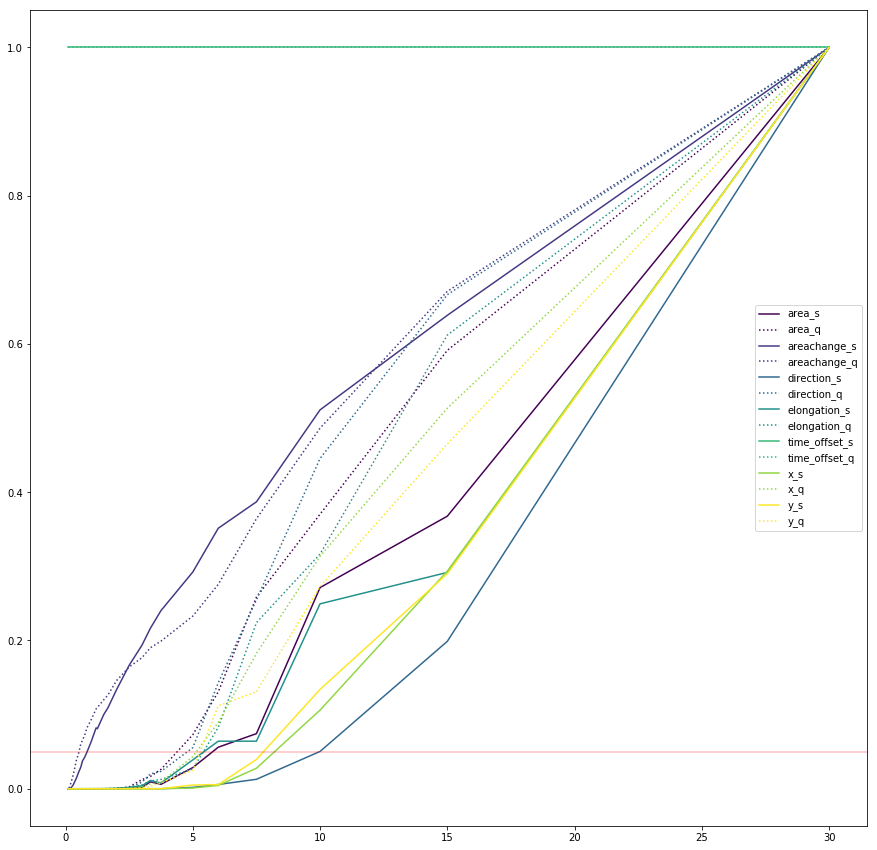

In [26]:
plt.rcParams['figure.figsize'] = (15, 15)
cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(r2[0.1][0].data_vars)-1)
time = [datetime.timedelta(minutes=i) for i in segment_sizes]
for i,var in enumerate(r2[0.1][0].data_vars):
    color = cmap(norm(i))
    for sq in range(2):
        plt.plot(segment_sizes,R[i,sq,:].T,label=var+['_s','_q'][sq],linestyle=['-','dotted'][sq],color=color)
plt.legend()
plt.axhline(y=0.05, color='r', linestyle='-', alpha=0.25)

In [28]:
P = np.delete(R,4,axis=0)

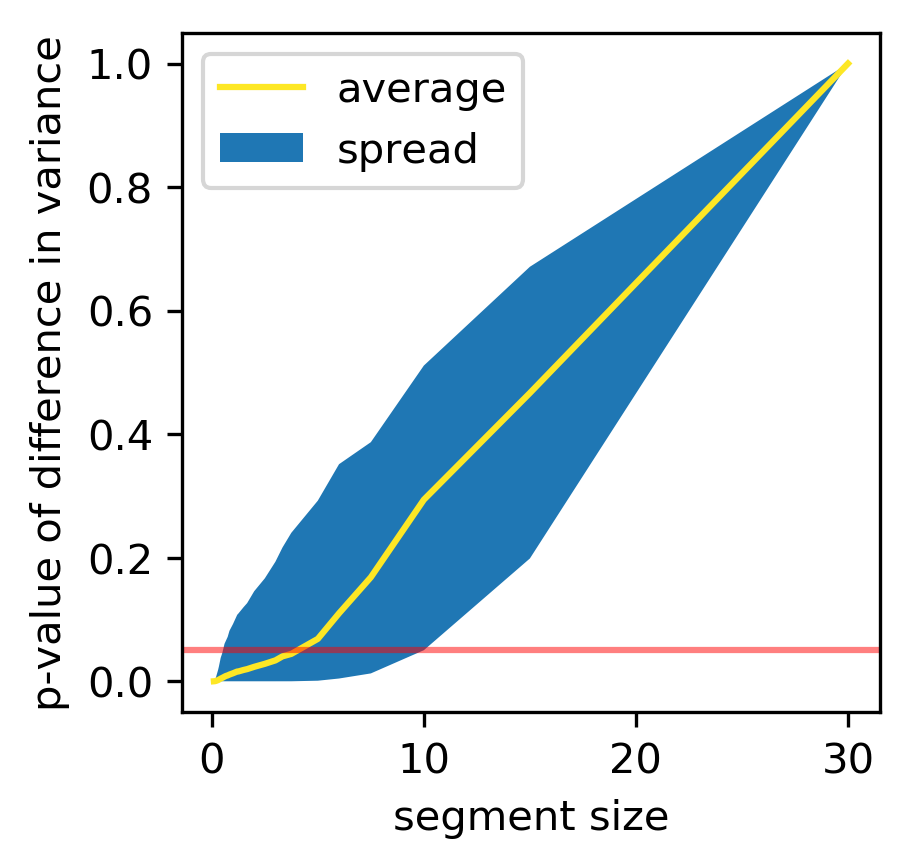

In [75]:
plt.rcParams['figure.figsize'] = (3,3)
cmap = matplotlib.cm.get_cmap('viridis')
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(r2[0.1][0].data_vars)-1)
time = [datetime.timedelta(minutes=i) for i in segment_sizes]
color = cmap(norm(i))
#for sq in range(2):
#    plt.plot(segment_sizes,P[:,sq,:].mean(axis=0).T,label=var+['_s','_q'][sq],linestyle=['-','dotted'][sq],color=color)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.plot(segment_sizes,P.mean(axis=(0,1)).T,color=color, label='average')
ax.fill_between(segment_sizes, P.min(axis=(0,1)), P.max(axis=(0,1)), label='spread')
#plt.legend()
ax.axhline(y=0.05, color='r', linestyle='-', alpha=0.5)
ax.set_xlabel('segment size')
ax.set_ylabel('p-value of difference in variance')
ax.legend()

In [177]:
x = P.min(axis=(0,1)) > 0.05

In [176]:
np.array(segment_sizes)[x]

array([ 30.,  15.,  10.])

In [184]:
ds

<xarray.Dataset>
Dimensions:      (rat: 8, session: 10, time: 45000)
Coordinates:
  * rat          (rat) object '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) object 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) object 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) object '5' '17' '29' '41' '53' '65' '77' ...
Data variables:
    area         (rat, session, time) float64 58.74 58.31 51.87 51.18 51.18 ...
    areachange   (rat, session, time) float64 14.86 13.48 12.28 11.85 12.71 ...
    direction    (rat, session, time) float64 147.6 137.3 135.0 129.3 130.0 ...
    elongation   (rat, session, time) float64 0.7867 0.7429 0.7395 0.7292 ...
    time_offset  (rat, session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.76 ...
    x            (rat, session, time) float64 -3.408 -3.288 -3.142 -2.898 ...
    y            (rat, session, time) float64 2.523 2.725 2.976 3.